In [1]:
# numpy to store time data
import numpy as np
# import simpsons rules from scikit learn
from scipy.integrate import simps
# import trapezoid method from numpy
from numpy import trapz
# import pandas to store timestamped spectra
import pandas as pd
# matplotlib for plotting
import matplotlib.pyplot as plt
import math
import datetime

# for smoothing
from scipy import sparse
from scipy.sparse.linalg import spsolve

from BaselineRemoval import BaselineRemoval

In [2]:
def nearest(items, pivot):
    '''Get the nearest item'''
    return min(items, key=lambda x: abs(x - pivot))

## Take inputs

In [83]:
start_time = input('enter experiment start time in hh:mm:ss format: ')

enter experiment start time in hh:mm:ss format: 11:00:49


In [95]:
raw_data = input('enter filename of raw data (.csv required): ')

enter filename of raw data (.csv required): DIBAL-H_day_1.csv


In [70]:
wavenumber_1 = int(input('enter start of wavenumber range to analyse (highest number (integer) / cm^-1): '))
wavenumber_2 = int(input('enter end of wavenumber range to analyse (lowest number (integer) / cm^-1): '))

enter start of wavenumber range to analyse (highest number (integer) / cm^-1): 1480
enter end of wavenumber range to analyse (lowest number (integer) / cm^-1): 1440


### Import the dataset from ICIR

In [96]:
# read in the csv file of spectra into dataframe
spectra_full = pd.read_csv(raw_data)

# set the index to be the wavenumbers (x axis)
spectra_full.set_index(spectra_full['Wavenumber (cm-1)'].astype(int),inplace=True)

# drop wavenumbers column with 6 d.p.
spectra_full.drop(columns = ['Wavenumber (cm-1)'], axis=1, inplace=True)

# get the nearest wavenumber range to the wavenumbers input
zoomed = spectra_full.loc[nearest(spectra_full.index, wavenumber_1)
                           :
                           nearest(spectra_full.index, wavenumber_2),
                           :]
# copy zoomed to use in baseline correction later
zoomed2 = zoomed.copy()

## Do baseline correction

In [97]:
polynomial_degree=1 #only needed for Modpoly and IModPoly algorithm

baseObj=[BaselineRemoval(zoomed2.iloc[:,i]) for i in range(len(zoomed2.columns))]

Imodpolys= [baseObj[i].ModPoly(polynomial_degree) for i in range(len(zoomed2.columns))]
        
baseline_corrected = pd.DataFrame(Imodpolys, index=zoomed2.columns, columns=zoomed2.index).transpose()


In [87]:
print('Nearest wavenumber range / cm^-1: {} - {}'.format(
    nearest(spectra_full.index, wavenumber_1),
    nearest(spectra_full.index, wavenumber_2)))

Nearest wavenumber range / cm^-1: 1480 - 1439


### Import the notes from ICIR report

In [98]:
# import the table of notes
notes = pd.read_excel('DIBAL_day_1_notes.xlsx')

# set the index as the message so it's easier to search
notes.set_index('Message', inplace=True)

# transform the Date/Time column into just time
notes['Time'] = notes['Date/Time'].dt.time

# convert this into a string
notes['Time_string'] = notes['Time'].astype(str)

# get the time in seconds
notes['seconds'] = [sum(x * int(t) for x, t in zip([3600, 60, 1], time.split(":")))
                             for time in notes['Time_string']]

# get the elapsed time by subtracting start time
start_time_secs = sum(x * int(t) for x, t in zip([3600, 60, 1], start_time.split(":")))
notes['Elapsed_Time_seconds'] = notes['seconds'] - start_time_secs

In [99]:
# get all possible elapsed timestamps of spectra
all_timestamps = pd.DataFrame(zoomed.columns, columns=['string'])

# convert the timestring to seconds
all_timestamps['seconds'] = [sum(x * int(t) for x, t in zip([3600, 60, 1], time.split(":")))
                             for time in all_timestamps['string']]
# set the index to be seconds
all_timestamps.set_index('seconds', inplace=True, drop=False)

In [100]:
notes

,seconds,Elapsed Time,Date/Time,Time,Time_string,Elapsed_Time_seconds
Message,,,,,,
start,40297,00:00:00,2022-11-02 11:11:37,11:11:37,11:11:37,648
Priming injection loop with N-nitrosodiethylamine for reference at 1 min,41987,00:28:10,2022-11-02 11:39:47,11:39:47,11:39:47,2338
injecting N-nitrosodiethylamine for 1 min ref,42093,00:29:56,2022-11-02 11:41:33,11:41:33,11:41:33,2444
priming with N-nitrosodiethylamine for 5 min ref,42677,00:39:40,2022-11-02 11:51:17,11:51:17,11:51:17,3028
injecting N-nitrosodiethylamine for 5 min ref,42753,00:40:56,2022-11-02 11:52:33,11:52:33,11:52:33,3104
...,...,...,...,...,...,...
priming injection loop for 5 minute run with N-methyl-N-nitrosoeurethane,59872,05:26:15,2022-11-02 16:37:52,16:37:52,16:37:52,20223
injected N-methyl-N-nitrosoeurethane for 5 min run,59887,05:26:30,2022-11-02 16:38:07,16:38:07,16:38:07,20238
started sample collection,60141,05:30:44,2022-11-02 16:42:21,16:42:21,16:42:21,20492


In [101]:
all_timestamps

,string,seconds
seconds,,
10,00:00:10,10
25,00:00:25,25
40,00:00:40,40
55,00:00:55,55
70,00:01:10,70
...,...,...
23477,06:31:17,23477
23492,06:31:32,23492
23507,06:31:47,23507


## Function for baseline smoothing

In [79]:
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

## Get AUC plot for a given note

In [80]:
def get_spectra(message, tref, tstart, tstop, avg, smooth, bcorr, l=100, a=0.1):
    '''Function to get the reference spectrum and the range of spectra to do AUC analysis with.
    
    message = the note made at time of injection
    tref = amount of time after injection to take reference spectrum / 15s
    tstart = time after injection to start gathering spectra for AUC plot
    tstop = time after injection to stop gathering data for AUC plot'''
    
    #define reference or reaction
    refreact = input('reference or reaction?')
    
    # get the elapsed time in seconds the note was made
    message_time = notes.loc[message]['Elapsed_Time_seconds']
    
    # take a reference spectrum
    reference_spectrum_time = message_time + tref
    # start collecting spectra
    start = message_time + tstart
    # stop collecting spectra
    stop = message_time + tstop
    
    # get the nearest spectrum to the reference spectrum time
    nearest_time = all_timestamps.loc[nearest(all_timestamps['seconds'], reference_spectrum_time), 'string']
    
    # get the previous and next spectrum to that reference
    prev_time = all_timestamps.loc[nearest(all_timestamps['seconds'], reference_spectrum_time-15), 'string']
    next_time = all_timestamps.loc[nearest(all_timestamps['seconds'], reference_spectrum_time+15), 'string']
    
    # get the range of spectra 
    start_time = all_timestamps.loc[nearest(all_timestamps['seconds'], start), 'string']
    stop_time = all_timestamps.loc[nearest(all_timestamps['seconds'], stop), 'string']
    
    if bcorr == True:
        zoomed = baseline_corrected
    elif bcorr == False:
        zoomed = zoomed2
    
    if smooth == False:
        # locate the reference spectrum in the zoomed in dataset
        nearest_ref_spectrum = zoomed.loc[:, nearest_time]
        avg_ref = zoomed.loc[:, prev_time : next_time].mean(axis=1)
        
        # locate the range of spectra for sample collection
        sample_range = pd.DataFrame(zoomed.loc[:, start_time:stop_time])
        
    elif smooth == True:
        #apply smoothing to the reference spectra
        nearest_ref_spectrum = pd.Series(baseline_als(zoomed.loc[:, nearest_time], lam=l, p=a), index=zoomed.index)
        avg_ref = pd.Series(baseline_als(zoomed.loc[:, prev_time : next_time].mean(axis=1),
                                         lam=l, p=a),index=zoomed.index)
                            
        # and to the range of spectra for sample collection
        sample_range = pd.DataFrame(zoomed.loc[:, start_time:stop_time])
        sample_range = pd.DataFrame([baseline_als(sample_range.iloc[:,i], lam=l, p=a)
                                     for i in range(len(sample_range.columns))]).transpose()
        sample_range.set_index(zoomed.index, inplace=True)
    
    if avg == True:
        #store the table of solvent subtracted spectra
        solvent_subtracted_spectra = sample_range.sub(avg_ref, axis='index')
    elif avg == False:
        #store the table of solvent subtracted spectra
        solvent_subtracted_spectra = sample_range.sub(nearest_ref_spectrum, axis='index')
    
    # get area under curve for each
    AUC_list = [simps(solvent_subtracted_spectra.iloc[:,i], dx=4) 
                for i in range(len(solvent_subtracted_spectra.columns))]
    AUC_df = pd.DataFrame(AUC_list,
                          columns=[refreact])
    
    return AUC_df

## Get AUC plots for 1 min reactions

In [15]:
note1 = input('type reference note for 1 min reaction')
note2 = input('type reaction note for 1 min reaction')
nitrosamine = input('type nitrosamine name')

type reference note for 1 min reactioninjected N-nitrosodiethylamine for 5 minute run


KeyboardInterrupt: Interrupted by user

reference or reaction?reference
reference or reaction?reaction
reference or reaction?reference
reference or reaction?reaction
reference or reaction?reference
reference or reaction?reaction
reference or reaction?reference
reference or reaction?reaction


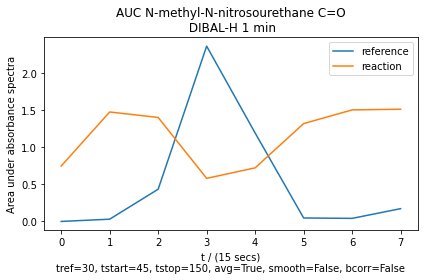

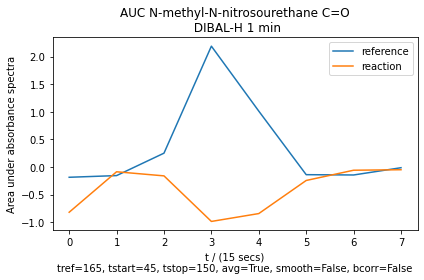

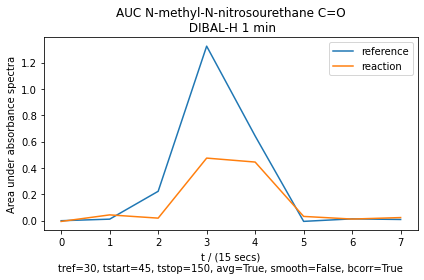

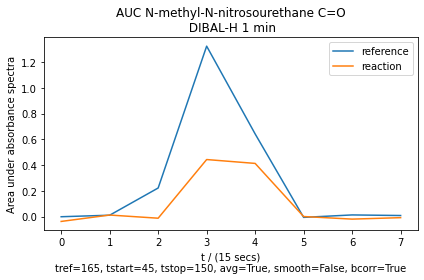

In [224]:
get_spectra(
    message=note1,
    tref=30,
    tstart=45,
    tstop=150,
    avg=True,
    smooth=False,
    bcorr=False).join(
    get_spectra(
        message=note2,
        tref=30,
        tstart=45,
        tstop=150,
        avg=True,
        smooth=False,
        bcorr=False)).plot()

plt.xticks(np.arange(0,7+1, 1))
plt.xlabel('''t / (15 secs)
tref=30, tstart=45, tstop=150, avg=True, smooth=False, bcorr=False''')
plt.ylabel('Area under absorbance spectra')
plt.title('AUC {}\n DIBAL-H 1 min'.format(nitrosamine))
plt.tight_layout()
plt.savefig(r'AUC_figs_2\DIBAL_1_{}_5.png'.format(nitrosamine))

get_spectra(
    message=note1,
    tref=165,
    tstart=45,
    tstop=150,
    avg=True,
    smooth=False,
    bcorr=False).join(
    get_spectra(
        message=note2,
        tref=165,
        tstart=45,
        tstop=150,
        avg=True,
        smooth=False,
        bcorr=False)).plot()

plt.xticks(np.arange(0,7+1, 1))
plt.xlabel('''t / (15 secs)
tref=165, tstart=45, tstop=150, avg=True, smooth=False, bcorr=False''')
plt.ylabel('Area under absorbance spectra')
plt.title('AUC {}\n DIBAL-H 1 min'.format(nitrosamine))
plt.tight_layout()
plt.savefig(r'AUC_figs_2\DIBAL_1_{}_6.png'.format(nitrosamine))

get_spectra(
    message=note1,
    tref=30,
    tstart=45,
    tstop=150,
    avg=True,
    smooth=False,
    bcorr=True).join(
    get_spectra(
        message=note2,
        tref=30,
        tstart=45,
        tstop=150,
        avg=True,
        smooth=False,
        bcorr=True)).plot()

plt.xticks(np.arange(0,7+1, 1))
plt.xlabel('''t / (15 secs)
tref=30, tstart=45, tstop=150, avg=True, smooth=False, bcorr=True''')
plt.ylabel('Area under absorbance spectra')
plt.title('AUC {}\n DIBAL-H 1 min'.format(nitrosamine))
plt.tight_layout()
plt.savefig(r'AUC_figs_2\DIBAL_1_{}_7.png'.format(nitrosamine))

get_spectra(
    message=note1,
    tref=165,
    tstart=45,
    tstop=150,
    avg=True,
    smooth=False,
    bcorr=True).join(
    get_spectra(
        message=note2,
        tref=165,
        tstart=45,
        tstop=150,
        avg=True,
        smooth=False,
        bcorr=True)).plot()

plt.xticks(np.arange(0,7+1, 1))
plt.xlabel('''t / (15 secs)
tref=165, tstart=45, tstop=150, avg=True, smooth=False, bcorr=True''')
plt.ylabel('Area under absorbance spectra')
plt.title('AUC {}\n DIBAL-H 1 min'.format(nitrosamine))
plt.tight_layout()
plt.savefig(r'AUC_figs_2\DIBAL_1_{}_8.png'.format(nitrosamine))



## Get AUC plots for 5 min reactions

In [113]:
note1 = input('type reference note for 5 min reaction')
note2 = input('type reaction note for 5 min reaction')
nitrosamine = input('type nitrosamine name')


type reference note for 5 min reactioninjecting N-nitrosodipropylamine for 5 minute ref
type reaction note for 5 min reactioninjecting N-nitrosodipropylamine for 5 min run
type nitrosamine nameN-nitrosodipropylamine


reference or reaction?reference
reference or reaction?reaction
reference or reaction?reference
reference or reaction?reaction
reference or reaction?reference
reference or reaction?reaction
reference or reaction?reference
reference or reaction?reaction


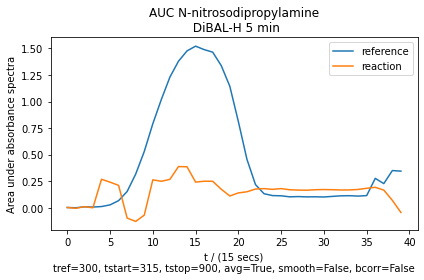

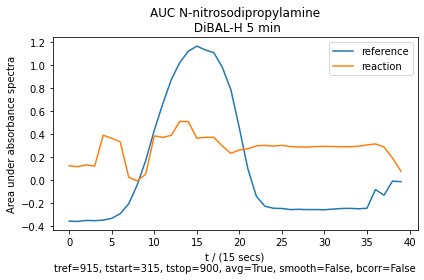

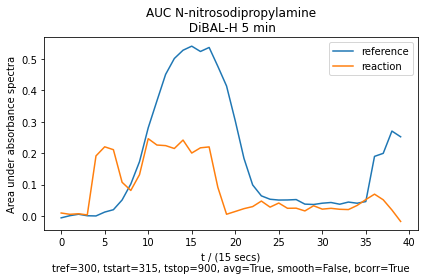

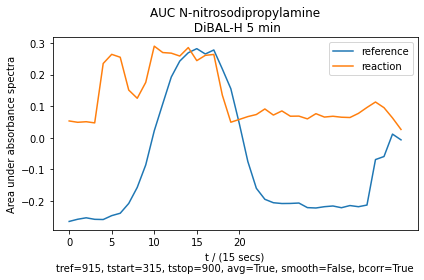

In [115]:
get_spectra(
    message=note1,
    tref=300,
    tstart=315,
    tstop=900,
    avg=True,
    smooth=False,
    bcorr=False).join(
    get_spectra(
        message=note2,
        tref=300,
        tstart=315,
        tstop=900,
        avg=True,
        smooth=False,
        bcorr=False)).plot()

plt.xticks(np.arange(0,40+1, 5))
plt.xlabel('''t / (15 secs)
tref=300, tstart=315, tstop=900, avg=True, smooth=False, bcorr=False''')
plt.ylabel('Area under absorbance spectra')
plt.title('AUC {}\n DiBAL-H 5 min'.format(nitrosamine))
plt.tight_layout()
plt.savefig(r'AUC_figs_2\DIBAL_5_{}_1.png'.format(nitrosamine))

get_spectra(
    message=note1,
    tref=915,
    tstart=315,
    tstop=900,
    avg=True,
    smooth=False,
    bcorr=False).join(
    get_spectra(
        message=note2,
        tref=915,
        tstart=315,
        tstop=900,
        avg=True,
        smooth=False,
        bcorr=False)).plot()

plt.xticks(np.arange(0,40+1, 5))
plt.xlabel('''t / (15 secs)
tref=915, tstart=315, tstop=900, avg=True, smooth=False, bcorr=False''')
plt.ylabel('Area under absorbance spectra')
plt.title('AUC {}\n DiBAL-H 5 min'.format(nitrosamine))
plt.tight_layout()
plt.savefig(r'AUC_figs_2\DIBAL_5_{}_2.png'.format(nitrosamine))

get_spectra(
    message=note1,
    tref=300,
    tstart=315,
    tstop=900,
    avg=True,
    smooth=False,
    bcorr=True).join(
    get_spectra(
        message=note2,
        tref=300,
        tstart=315,
        tstop=900,
        avg=True,
        smooth=False,
        bcorr=True)).plot()

plt.xticks(np.arange(0,40+1, 5))
plt.xlabel('''t / (15 secs)
tref=300, tstart=315, tstop=900, avg=True, smooth=False, bcorr=True''')
plt.ylabel('Area under absorbance spectra')
plt.title('AUC {}\n DiBAL-H 5 min'.format(nitrosamine))
plt.tight_layout()
plt.savefig(r'AUC_figs_2\DIBAL_5_{}_3.png'.format(nitrosamine))

get_spectra(
    message=note1,
    tref=915,
    tstart=315,
    tstop=900,
    avg=True,
    smooth=False,
    bcorr=True).join(
    get_spectra(
        message=note2,
        tref=915,
        tstart=315,
        tstop=900,
        avg=True,
        smooth=False,
        bcorr=True)).plot()

plt.xticks(np.arange(0,20+1, 5))
plt.xlabel('''t / (15 secs)
tref=915, tstart=315, tstop=900, avg=True, smooth=False, bcorr=True''')
plt.ylabel('Area under absorbance spectra')
plt.title('AUC {}\n DiBAL-H 5 min'.format(nitrosamine))
plt.tight_layout()
plt.savefig(r'AUC_figs_2\DIBAL_5_{}_4.png'.format(nitrosamine))